# Task C: Data Visualisation

In [1]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import json
import matplotlib.pyplot as plt

    
    

# Question a 
## Receive climate data from producer 1

<IPython.core.display.Javascript object>


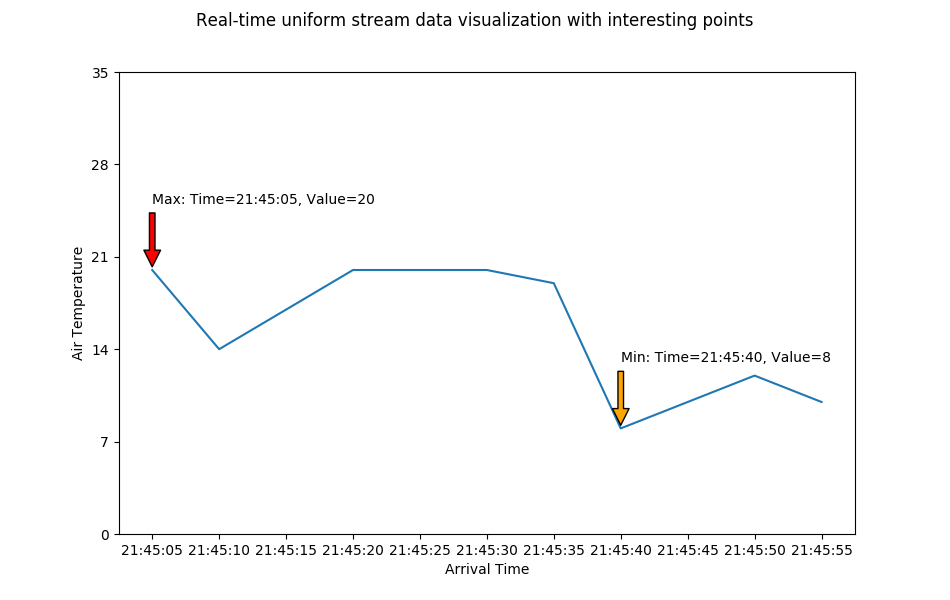

In [ ]:
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'StopFire'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature')
        ax.set_ylim(0,35) 
        ax.set_yticks([0,7,14,21,28,35])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = message.value.decode('utf-8')
            json_data = json.loads(data)
            # only deals with climate data
            if json_data['sender_id'] == 'producer_1':
                # append data to list
                x.append(json_data['created_time'])
                y.append((json_data['air_temperature_celcius']))
                # print(y)
                # we start plotting only when we have 10 data points
                if len(y) > 10:
                    ax.clear()
                    ax.plot(x, y)
                    ax.set_xlabel('Arrival Time')
                    ax.set_ylabel('Air Temperature')
                    # set range and tick 
                    ax.set_ylim(0,35) 
                    ax.set_yticks([0,7,14,21,28,35])
                    annotate_max(x,y)
                    annotate_min(x,y)
                    fig.canvas.draw()
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

# Question b (i)
## Visualize historic data from mongo
## If the barchart doesn't show up please run twice <3
## if it doesn't work please try turn off the producer <3 <3

04:44:50-->179fire records
04:26:30-->169fire records
04:44:40-->74fire records
04:08:10-->70fire records
04:26:20-->52fire records
04:20:40-->47fire records
04:38:40-->34fire records
04:02:20-->33fire records
04:14:20-->26fire records
04:28:10-->24fire records


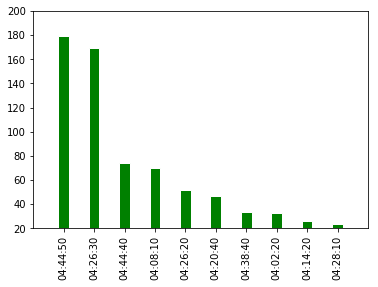

In [6]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np

client = MongoClient()
db = client.fit5148_assignment_db
coll_hotspot = db.hotspot
coll_climate = db.climate



project = {'$project':{'datetime':1,'count':1}}
group = {'$group':{'_id':'$datetime','count':{'$sum':1}}}
sort = {'$sort':{'count':-1}}
limit = {'$limit':10}
results = coll_hotspot.aggregate([group,project,sort,limit])
result = list(results)
for r in result:
    time = r['_id'].isoformat()
    count = str(r['count'])
    print(time[11:]+'-->'+count+'fire records')
x_axis = []
for r in result:
    time = r['_id'].isoformat()
    x_axis.append(time[11:])
ind = np.arange(len(x_axis))

y_axis = []
for r in result:
    count = r['count']
    y_axis.append(count)

plt.bar(ind,y_axis,width=0.35,facecolor='green',edgecolor='white')
plt.xticks(ind,x_axis,rotation = 90)
#plt.yticks(y_axis,y_axis)
plt.xlim(-1,10)
plt.ylim(20,200)
plt.show()   



# Question b(ii)
## Join and visualize historic data 

In [ ]:
import gmplot
import webbrowser
# join data from two collection based on model 
project = {'$project':{'latitude':1,'longitude':1,'surface_temperature_celcius':1,'climate.air_temperature_celcius':1,'climate.relative_humidity':1,'confidence':1}}
lookup = {'$lookup':{'from':'climate','localField':'date','foreignField':'date','as':'climate'}}  
unwind = {'$unwind':'$climate'}
results = coll_hotspot.aggregate([lookup,unwind,project])
result = list(results)
# Generate map 
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 10)
gmap.marker(-37.812015244225677, 144.951471202974, 'blue')

# get data and visualize
for r in result:
    surfacetemp = 'surface temp: ' + str(r['surface_temperature_celcius'])
    confidence = ' confidence: ' + str(r['confidence'])
    airtemp = ' air temp: ' + str(r['climate']['air_temperature_celcius'])
    relativehum = ' relative humidity: ' + str(r['climate']['relative_humidity'])
    label = surfacetemp + confidence + airtemp + relativehum
    gmap.marker(r['latitude'],r['longitude'], 'blue', title=label )
gmap.draw("map.html")
webbrowser.open_new("map.html")